In [1]:


#importing library
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import warnings
warnings.filterwarnings('ignore')
#!pip install ydata-profiling
#from ydata_profiling import ProfileReport
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error, r2_score
from sklearn.preprocessing import StandardScaler
import streamlit as st
import pickle
import joblib

#loading dataset


df = pd.read_csv(r'C:\Users\Anthony Izevbokun\Documents\TRAINING\PYTHON\class1\City_Types.csv')
df.head()

#exploring dataset
print(df.shape)
print(df.info())
print(df.describe())











(52704, 9)
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 52704 entries, 0 to 52703
Data columns (total 9 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   Date    52704 non-null  object 
 1   City    52704 non-null  object 
 2   CO      52704 non-null  float64
 3   NO2     52704 non-null  float64
 4   SO2     52704 non-null  float64
 5   O3      52704 non-null  float64
 6   PM2.5   52704 non-null  float64
 7   PM10    52704 non-null  float64
 8   Type    52704 non-null  object 
dtypes: float64(6), object(3)
memory usage: 3.6+ MB
None
                 CO           NO2           SO2            O3         PM2.5  \
count  52704.000000  52704.000000  52704.000000  52704.000000  52704.000000   
mean     508.030472     29.616492     22.387250     53.423668     32.931045   
std      692.274824     23.984409     34.285823     42.225556     43.833691   
min        0.000000      0.900000      0.000000      0.000000      0.300000   
25%      187.000000   

In [2]:

df.isna().sum()

df.duplicated().sum()

#profile = ProfileReport(df,title='city type')
#profile.to_notebook_iframe()

# 1. Define the numeric columns you want to analyze
pollutants = ['CO', 'NO2', 'SO2', 'O3', 'PM2.5', 'PM10']

#changing data
df['Date'] = pd.to_datetime(df['Date'])


# This step is crucial to avoid the TypeError
df_numeric = df.set_index('Date')[pollutants]


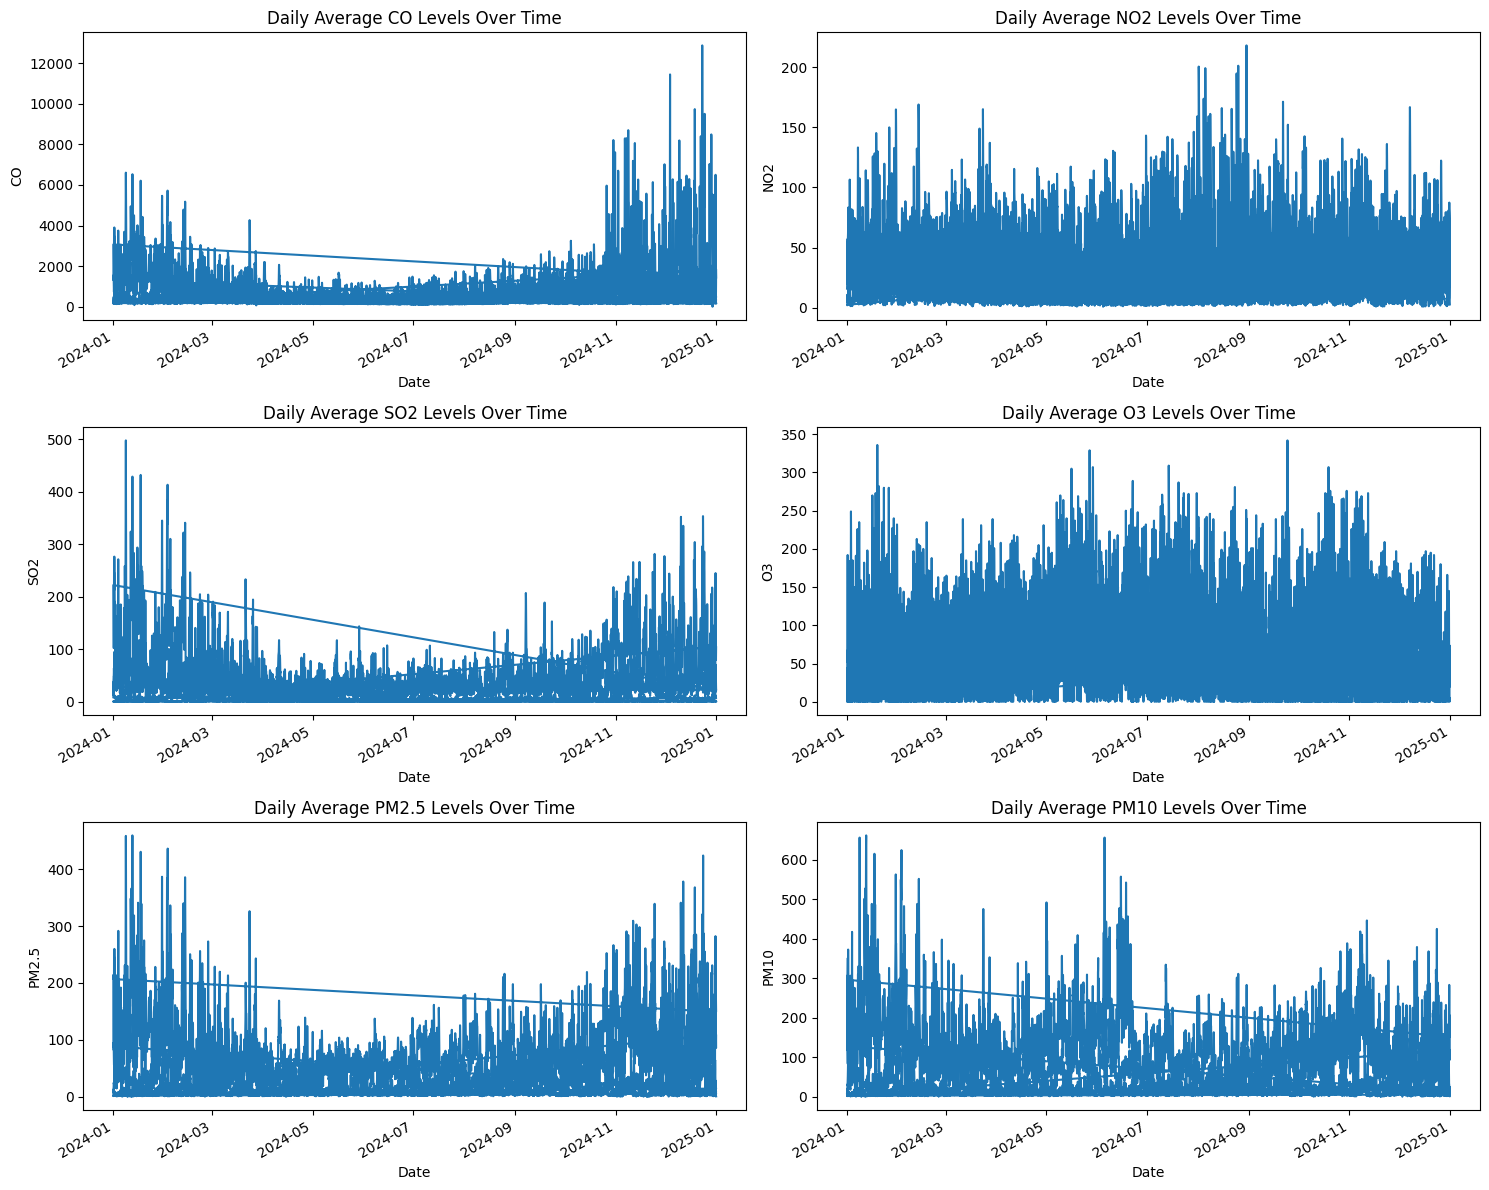

In [3]:

plt.figure(figsize=(15, 12))
for i, pollutant in enumerate(pollutants, 1):
    plt.subplot(3, 2, i)
    df_numeric[pollutant].plot(ax=plt.gca())
    plt.title(f'Daily Average {pollutant} Levels Over Time')
    plt.xlabel('Date')
    plt.ylabel(pollutant)
plt.tight_layout()
plt.show()


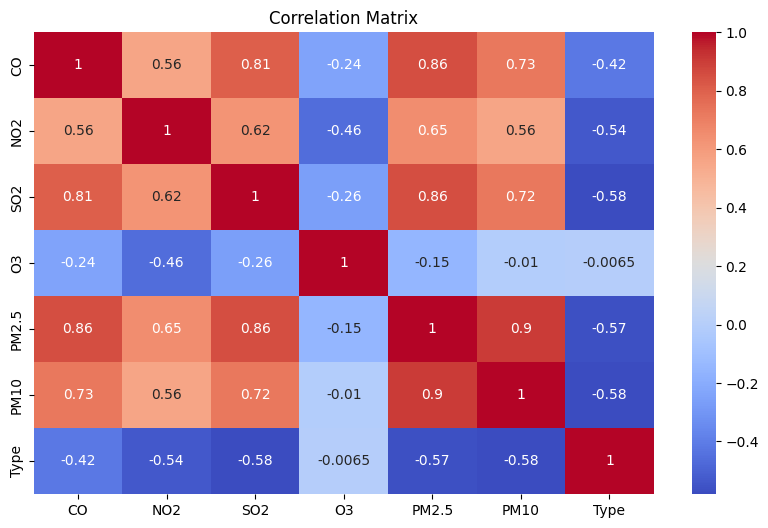

In [4]:

#droping columns
df.drop(['Date', 'City'], inplace=True, axis=1)

df.shape

df['Type'] = df['Type'].map({'Industrial': 0, 'Residential': 1})

#visualizing our dataset
plt.figure(figsize=(10, 6))
sns.heatmap(df.corr(numeric_only=True), annot=True, cmap='coolwarm')
plt.title("Correlation Matrix")
plt.show()


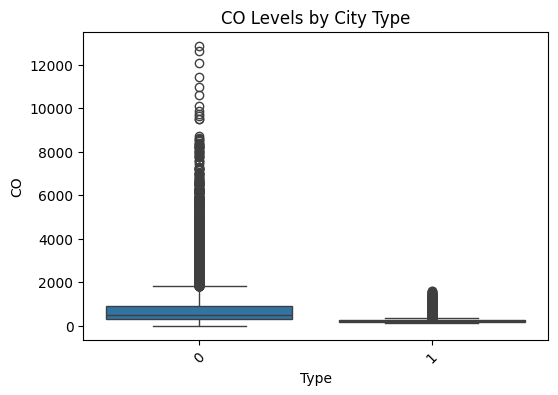

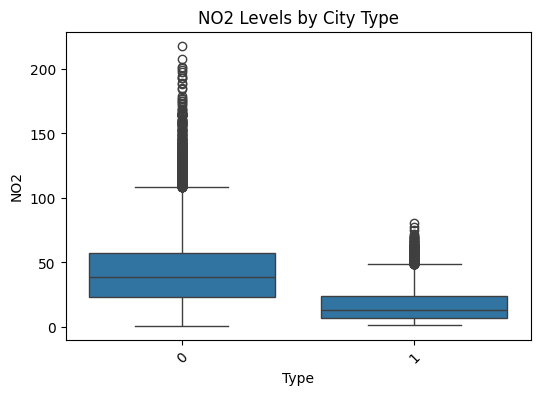

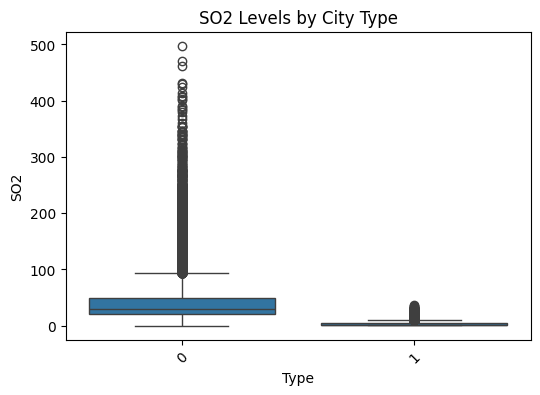

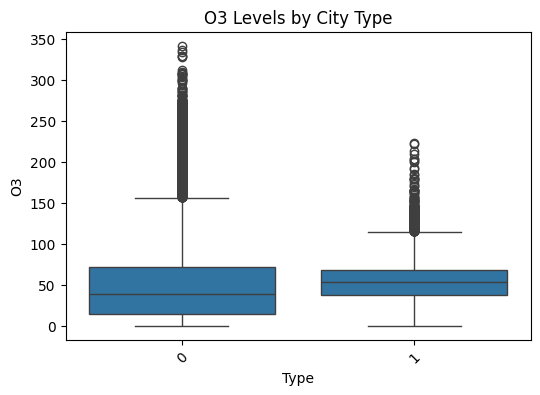

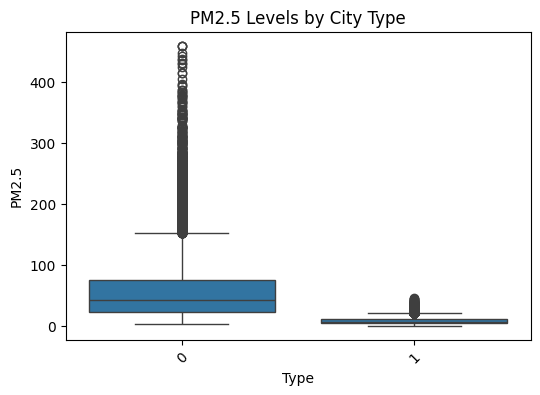

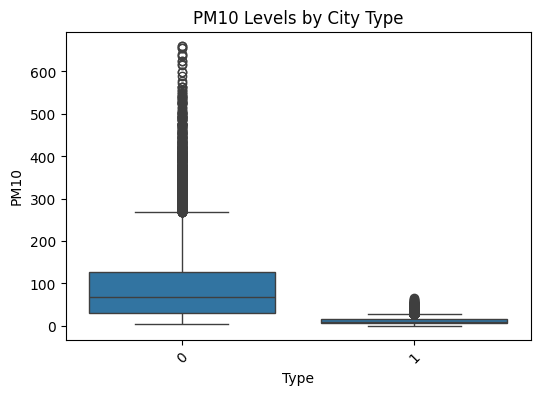

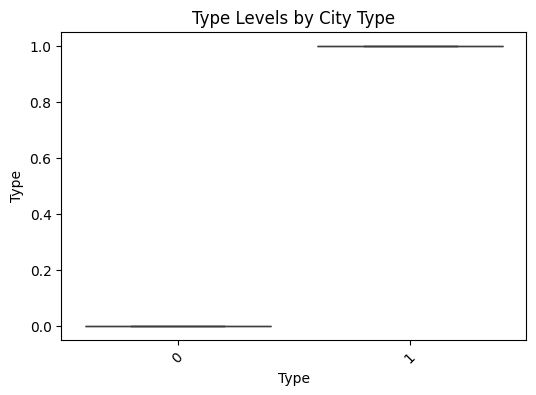

In [5]:
for col in df:
    plt.figure(figsize=(6, 4))
    sns.boxplot(x='Type', y=col, data=df)
    plt.title(f'{col} Levels by City Type')
    plt.xticks(rotation=45)
    plt.show()


In [6]:

numeric_cols = df.select_dtypes(include=['float64', 'int64']).columns

for col in numeric_cols:
    if col == 'CO':
        df[col] = np.log1p(df[col])
        continue

#target
x=df.drop('Type' ,axis=1)
y=df['Type']

#spliting datset
x_train,x_test,y_train,y_test=train_test_split(x,y,test_size=0.2,random_state=42)

#standardizing dataset
scale=StandardScaler()
df_scaled=scale.fit_transform(x)
X_train = scale.fit_transform(x_train)
X_test = scale.transform(x_test)

#trainig and prdicting model
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score,classification_report,confusion_matrix
model=LogisticRegression()
model.fit(x_train,y_train)

y_pred=model.predict(x_test)
model_class=classification_report(y_test,y_pred)
model_accu = accuracy_score(y_test, y_pred)
model_prec = precision_score(y_test, y_pred)
model_cm= confusion_matrix(y_test,y_pred)

print(f"LogisticRegression Classification Report:\n{model_class}")
print(f"LogisticRegression Accuracy: {model_accu:.2f}")
print(f"LogisticRegression Precision: {model_prec:.2f}")
print(f"LogisticRegression Confusion Matrix:\n{model_cm}")


LogisticRegression Classification Report:
              precision    recall  f1-score   support

           0       0.98      0.97      0.98      5208
           1       0.97      0.98      0.98      5333

    accuracy                           0.98     10541
   macro avg       0.98      0.98      0.98     10541
weighted avg       0.98      0.98      0.98     10541

LogisticRegression Accuracy: 0.98
LogisticRegression Precision: 0.97
LogisticRegression Confusion Matrix:
[[5054  154]
 [ 105 5228]]


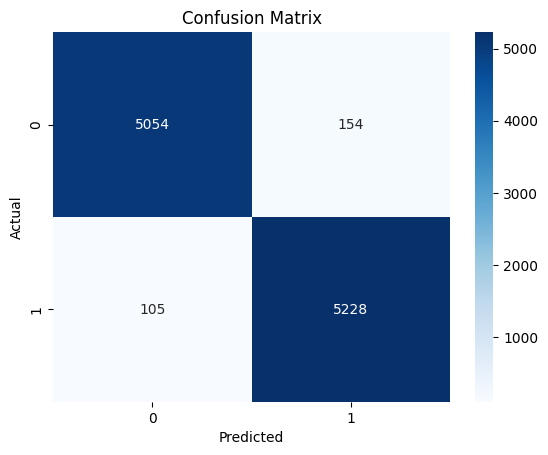

Fitting 5 folds for each of 24 candidates, totalling 120 fits
Best Parameters: {'max_depth': 20, 'min_samples_leaf': 1, 'min_samples_split': 2, 'n_estimators': 250}


In [7]:

#visual confusion matrix
sns.heatmap(model_cm, annot=True, fmt='d', cmap='Blues')
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.title('Confusion Matrix')
plt.show()

from sklearn.model_selection import GridSearchCV
from sklearn.ensemble import RandomForestClassifier

# Define the model
rf = RandomForestClassifier(random_state=42)

# Set up the hyperparameter grid
param_grid = {
    'n_estimators': [250, 300],
    'max_depth': [None, 10, 20],
    'min_samples_split': [2, 5],
    'min_samples_leaf': [1, 2],
}

# Initialize GridSearchCV
grid_search = GridSearchCV(estimator=rf,
                           param_grid=param_grid,
                           cv=5,
                           scoring='accuracy',
                           n_jobs=-1,
                           verbose=2)

grid_search.fit(x_train, y_train)

print("Best Parameters:", grid_search.best_params_)


In [8]:
# Use the best model to predict
best_model = grid_search.best_estimator_
y_pred_best = best_model.predict(x_test)

print("Accuracy (Tuned):", accuracy_score(y_test, y_pred_best))
print(classification_report(y_test, y_pred_best))

""" The model is very good at predicting both classes, with slightly better precision for class 0.


Overall Model Performance
Accuracy: 0.98 → The model predicts 98% of all cases correctly.

Equal average of all classes — great when class distribution is balanced or fairness across classes is needed.

 Adjusted for class frequency; also 0.97, indicating good performance across both classes.


"""


Accuracy (Tuned): 0.9891850868039086
              precision    recall  f1-score   support

           0       0.99      0.99      0.99      5208
           1       0.99      0.99      0.99      5333

    accuracy                           0.99     10541
   macro avg       0.99      0.99      0.99     10541
weighted avg       0.99      0.99      0.99     10541



' The model is very good at predicting both classes, with slightly better precision for class 0.\n\n\nOverall Model Performance\nAccuracy: 0.98 → The model predicts 98% of all cases correctly.\n\nEqual average of all classes — great when class distribution is balanced or fairness across classes is needed.\n\n Adjusted for class frequency; also 0.97, indicating good performance across both classes.\n\n\n'

In [9]:

with open('rf_best_model.pkl', 'wb') as f:
    pickle.dump(best_model, f)